# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp


from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir
# import u19_pipeline.ephys_sync as ephys
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from element_interface.utils import find_full_path

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils


c:\Users\MiniVR-8\miniconda3\envs\u19_pipeline_python_env\Lib\site-packages\datajoint\plugin.py:4: UserWarning: Module scripts was already imported from None, but c:\experiments\u19-pipeline-python is being added to sys.path
  import pkg_resources
[2025-10-24 11:16:22,600][INFO]: DataJoint 0.14.6 connected to u19prod@datajoint00.pni.princeton.edu:3306


In [3]:
#Behavior data
behavior = dj.create_virtual_module('behavior', 'u19_behavior')

In [89]:
def fix_trial_times(synced_iteration_vector, synced_time_vector, behavior_time_vector, nidq_sampling_rate):
# Check where is more likely we miss an iteration pulse and insert it to iteration_vector

    new_synced_iteration_vector = synced_iteration_vector.copy()
    new_synced_time_vector = synced_time_vector.copy()

    diff_time_test = new_synced_time_vector[2:50] - behavior_time_vector[1:49]
    pulse_greater_than_virmen = np.where(diff_time_test > 0)
    pulse_greater_than_virmen = pulse_greater_than_virmen[0]+0
    if pulse_greater_than_virmen.shape[0] == 0:
        #print('we have a special case of extra pulse beginning')
        new_synced_iteration_vector = np.delete(new_synced_iteration_vector, 1)
        new_synced_time_vector = (new_synced_iteration_vector-new_synced_iteration_vector[0])/nidq_sampling_rate

    for i in range(100):
        diff_time = new_synced_time_vector[0:] - behavior_time_vector[0:new_synced_time_vector.shape[0]]
        pulse_greater_than_virmen = np.where(diff_time > 0)
        pulse_greater_than_virmen = pulse_greater_than_virmen[0]+0

        if pulse_greater_than_virmen.shape[0] == 0:
            break

        #print(i)
        #print(new_synced_time_vector[pulse_greater_than_virmen[0]-2:pulse_greater_than_virmen[0]+3])
        #print(behavior_time_vector[pulse_greater_than_virmen[0]-2:pulse_greater_than_virmen[0]+3])
        #print(pulse_greater_than_virmen[0])

        if pulse_greater_than_virmen[0] > 3:
            median_diff = np.median(new_synced_time_vector[0:pulse_greater_than_virmen[0]-3]-behavior_time_vector[0:pulse_greater_than_virmen[0]-3])
        else:
            median_diff = -0.015

        if median_diff > -0.01:
            comp_value_l = -0.015
            comp_value_g = -0.005
        else:
            comp_value_l = median_diff*1.3
            comp_value_g = median_diff*0.7

        diff_time_iter_missing_pulse = behavior_time_vector[pulse_greater_than_virmen[0]] - behavior_time_vector[pulse_greater_than_virmen[0]-1]
        #print('missing time in iter pulses', behavior_time_vector[pulse_greater_than_virmen[0]])
        #print('time_next_missing_pulse', diff_time_iter_missing_pulse)
        diff_iter_add = np.floor(diff_time_iter_missing_pulse*nidq_sampling_rate)
        value_insert_iteration = new_synced_iteration_vector[pulse_greater_than_virmen[0]-1] + diff_iter_add

        #print('value_insert_iteration', value_insert_iteration)

        new_synced_iteration_vector = np.insert(new_synced_iteration_vector, pulse_greater_than_virmen[0], value_insert_iteration)

        if new_synced_iteration_vector.shape[0] > behavior_time_vector.shape[0]:
            new_synced_iteration_vector = np.delete(new_synced_iteration_vector, pulse_greater_than_virmen[0]+1)
            #new_synced_iteration_vector = new_synced_iteration_vector[:-1]

        if pulse_greater_than_virmen[0] < (new_synced_time_vector.shape[0]-1):
            idx = pulse_greater_than_virmen[0]
            new_synced_time_vector = (new_synced_iteration_vector-new_synced_iteration_vector[0])/nidq_sampling_rate
            if idx+10 > (new_synced_time_vector.shape[0]-1):
                idx_final = new_synced_time_vector.shape[0]-1
                diff_vectorin = (new_synced_time_vector[idx+1:idx_final]- behavior_time_vector[idx+1:idx_final])
            else:
                diff_vectorin = (new_synced_time_vector[idx+1:idx+10]- behavior_time_vector[idx+1:idx+10])
            #print(diff_vectorin)
            diff_inserted_iter = np.median(diff_vectorin)
            #print('diff_in new inserted iter', diff_inserted_iter)
            if diff_inserted_iter < comp_value_l:
                #print('extra diff !!!!')
                diff_behavior = behavior_time_vector[idx+1] - behavior_time_vector[idx]
                idx_next_iter = np.where(new_synced_time_vector > behavior_time_vector[idx+1])
                #print('diff_behavior', diff_behavior)
                idx_next_iter = idx_next_iter[0][0]
                #print('idx_next_iter', idx_next_iter)
                #print('idx+1', idx+1)
                if diff_behavior > 0.1 and idx_next_iter > idx+3:
                    #print('bajale a indx_next_iter', idx_next_iter)
                    idx_next_iter = idx+3
                if idx_next_iter > idx+2:
                    #print('more than one to remove')
                    int_array_step = np.arange(idx+1, idx_next_iter-1, dtype=np.int64)
                    new_synced_iteration_vector = np.delete(new_synced_iteration_vector, int_array_step)
                else:
                    new_synced_iteration_vector = np.delete(new_synced_iteration_vector, [idx+1])
                #print(new_synced_time_vector[pulse_greater_than_virmen[0]-2:pulse_greater_than_virmen[0]+4])
            elif diff_inserted_iter > comp_value_g and diff_inserted_iter < 0:
                if new_synced_iteration_vector.shape[0] < behavior_time_vector.shape[0]:
                    #print('less diff now, insert one iteration')
                    #print('diff_inserted_iter', diff_inserted_iter)
                    #print('median_diff', median_diff, 'comp_value_g', comp_value_g)
                    #print('diff_vectorin', diff_vectorin)
                    value_insert = int((new_synced_iteration_vector[pulse_greater_than_virmen[0]]+new_synced_iteration_vector[pulse_greater_than_virmen[0]+1])/2)    
                    new_synced_iteration_vector = np.insert(new_synced_iteration_vector, pulse_greater_than_virmen[0]+1, value_insert)

                
        new_synced_time_vector = (new_synced_iteration_vector-new_synced_iteration_vector[0])/nidq_sampling_rate

        #print(new_synced_time_vector[pulse_greater_than_virmen[0]-2:pulse_greater_than_virmen[0]+4])
        #print(behavior_time_vector[pulse_greater_than_virmen[0]-2:pulse_greater_than_virmen[0]+4])

    return new_synced_iteration_vector, new_synced_time_vector



In [90]:
def sync_evaluation_process2(synced_time_vector, behavior_time_vector):

    status = 1
    diff_vector = synced_time_vector - behavior_time_vector
    num_iter = diff_vector.shape[0]

    max_diff = max(diff_vector)
    median_general = np.median(diff_vector)

    num_div= 10
    median_diff_percent = np.empty([num_div])
    median_diff_abs = np.empty([num_div])
    for j in range(num_div):
        start_iter = int(j*num_iter/num_div)
        end_iter = int((j+1)*num_iter/num_div)
        median_diff_percent[j] = (np.median(diff_vector[start_iter:end_iter])-median_general)*100/median_general
        median_diff_abs[j] = (np.median(diff_vector[start_iter:end_iter])-median_general)


    if max_diff <= 0 and np.max(np.abs(median_diff_abs)) < 0.005:
        pass
    else:
        status = 0
        print(median_general)
        plt.plot(median_diff_abs)

    return status
        



In [91]:
recording_query = "recording_id >= 500"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_keys = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


session_fields = ['subject_fullname', 'session_date', 'session_number']
session_keys = (recording.Recording.BehaviorSession & recording_query).fetch(*session_fields, as_dict=True, order_by='recording_id')


recording_keys

[{'recording_id': np.int64(500)},
 {'recording_id': np.int64(501)},
 {'recording_id': np.int64(502)},
 {'recording_id': np.int64(503)},
 {'recording_id': np.int64(504)},
 {'recording_id': np.int64(505)},
 {'recording_id': np.int64(506)},
 {'recording_id': np.int64(507)}]

# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

### Read nidaq file and behavior data

\\cup.pni.princeton.edu\braininit\Data\Raw\electrophysiology\jyanar\jyanar_ya054\20251011_g0\ya054_20251011_g0
nChan: 4, nFileSamp: 111367791
mode deduction:  pulse_signal
0
[]
[]
Synced perfectly xxxxxxxxxxxxxx
-0.003629949873119598
{'subject_fullname': 'jyanar_ya054', 'session_date': datetime.date(2025, 10, 11), 'session_number': np.int64(0)}
{'recording_id': np.int64(500)}
143


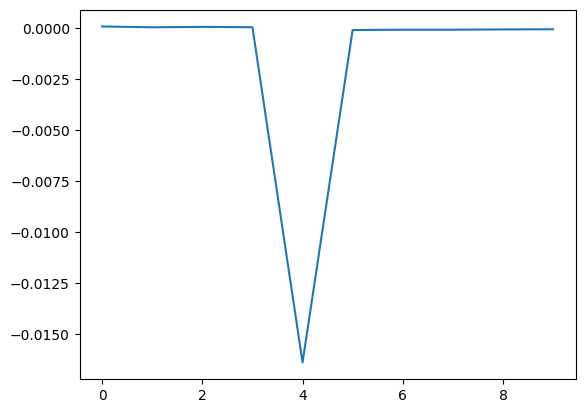

In [92]:
for idx_session in range(len(recording_keys)):
    recording_key = recording_keys[idx_session]
    session_key = session_keys[idx_session]

    session_dir = find_full_path(get_ephys_root_data_dir(),
                                get_session_directory(recording_key))
    print(session_dir)
    #session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
    #Check if session is Nidq or OneBox
    nidq_session = list(session_dir.glob('*nidq.bin*'))
    obx_session = list(session_dir.glob('*obx.bin*'))

    if len(nidq_session) == 0 and len(obx_session) == 0:
        print('No session found')
    elif len(nidq_session) > 0:
        ephys_session_fullpath = nidq_session[0]
    else:
        ephys_session_fullpath = obx_session[0]

    #Nidaq file
    nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
    nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


    # 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
    new_trial_channel = 1
    new_iteration_channel = 2
    # If PXIe card (nidq) card use for recording deduce digital channels
    if nidq_meta['typeThis'] == 'nidq':
        digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
    # If onebox card (obx) card use for recording digital channels are 0-2
    else:
        digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
        # If no sync pulse found trial and iteration signals are 0 & 1 respectively
        channel0_pulses = np.where(np.diff(digital_array[0])==1)[0].shape[0]
        channel1_pulses = np.where(np.diff(digital_array[1])==1)[0].shape[0]

        if channel0_pulses > channel1_pulses:
            new_trial_channel = 1
            new_iteration_channel = 0
        else:
            new_trial_channel = 0
            new_iteration_channel = 1

    
    thissession = behavior.TowersBlock().Trial() & session_key
    behavior_time, iterstart, beh_num_iterations = thissession.fetch('trial_time', 'vi_start', 'iterations')

    mode = None   #Default for sessions before 12/01/2021
    #mode = 'pulses'    #Default for sessions after 12/01/2021
    iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[new_trial_channel,:], digital_array[new_iteration_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode=mode)
    #                             get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal,


    for i in range(len(iteration_dict['iter_start_idx'])):
        #print('fixing trial ',i)
        iteration_dict['iter_start_idx'][i],iteration_dict['iter_times_idx'][i] =\
            fix_trial_times(iteration_dict['iter_start_idx'][i], iteration_dict['iter_times_idx'][i], behavior_time[i].flatten(), nidq_sampling_rate)


    # Check # of trials and iterations match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)


    print(trial_count_diff)
    print(trials_diff_iteration_big)
    print(trials_diff_iteration_small)


    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])

    for i in range(len(iteration_dict['iter_start_idx'])):
        synced_time_vector = iteration_dict['iter_times_idx'][i]
        behavior_time_vector = behavior_time[i].flatten()
        status = sync_evaluation_process2(synced_time_vector, behavior_time_vector)
        if status == 0:
            print(session_key)
            print(recording_key)
            print(i)
            if i!=0:
                break
    
    if status == 0:
        break
        


In [93]:
it_times = synced_time_vector
beh_times = behavior_time_vector

print(it_times.shape[0])
print(beh_times.shape[0])

1092
1092


In [94]:
if it_times.shape[0] >= beh_times.shape[0]:
    diff_vector = np.diff(it_times[:beh_times.shape[0]] - beh_times)
else:
    diff_vector = np.diff(it_times - beh_times[:it_times.shape[0]])

import scipy
peaks, _ = scipy.signal.find_peaks(diff_vector, height=0.05, distance=20)
peaks

array([], dtype=int64)

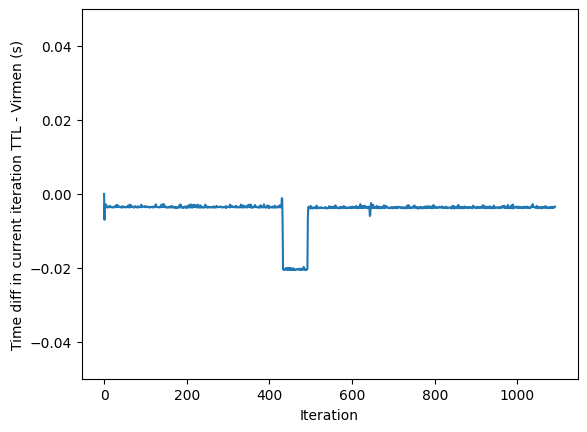

In [95]:
#plt.plot(np.diff(it_times - beh_times[:it_times.shape[0]]))
plt.plot((it_times - beh_times[:it_times.shape[0]]))
#plt.plot((np.diff(beh_times[:it_times.shape[0]])))
plt.plot(peaks, diff_vector[peaks], "x")
plt.ylabel('Time diff in current iteration TTL - Virmen (s)')
plt.xlabel('Iteration')
plt.ylim([-0.05, 0.05])
plt.show()

Text(0.5, 0, 'Iteration')

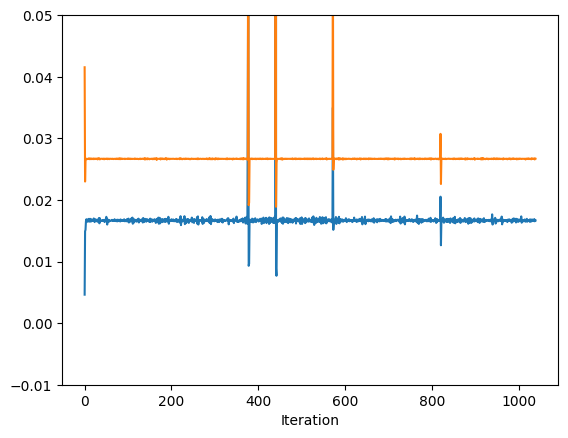

In [77]:
plt.plot(np.diff(synced_time_vector))
plt.plot(np.diff(beh_times)+0.01)
#plt.plot((np.diff(beh_times[:it_times.shape[0]])))
#plt.plot(peaks, diff_vector[peaks], "x")
plt.ylim([-0.01, 0.05])
plt.xlabel('Iteration')


In [79]:
difo =  np.pad(np.diff(synced_time_vector), (1, 0), 'constant', constant_values=(0,0))
difo2 =  np.pad(np.diff(beh_times), (1, 0), 'constant', constant_values=(0,0))

peaks_ttl_pulses, _ = scipy.signal.find_peaks(difo, height=0.02, distance=20)
peaks_virmen_iter, _ = scipy.signal.find_peaks(difo2, height=0.02, distance=20)
print(peaks_ttl_pulses)
print(peaks_virmen_iter)

[378 441 573 821]
[  1 378 441 573 821]


In [35]:
print(new_synced_time_vector[0:8])
print(beh_times[0:8])

[0.       0.007491 0.021252 0.026103 0.042834 0.059466 0.076263 0.092895]
[0.        0.0211323 0.0280628 0.039895  0.0565428 0.0732742 0.0899299
 0.106587 ]


In [36]:
print(new_synced_time_vector[peaks_ttl_pulses[0]-4:peaks_ttl_pulses[0]+4])
print(beh_times[peaks_ttl_pulses[0]-4:peaks_ttl_pulses[0]+4])


[5.55954296 5.57633996 5.59313696 5.63339696 5.69025595 5.69966095
 5.70906595 5.72579695]
[5.573194  5.5898204 5.606539  5.62318   5.703671  5.710857  5.7230883
 5.7397785]


In [37]:
print(new_synced_time_vector[-4:])
print(beh_times[-4:])


[17.25903286 17.27582986 18.75782685 18.83296785]
[17.256289 17.272928 17.289602 17.306309]


(0.0, 0.11)

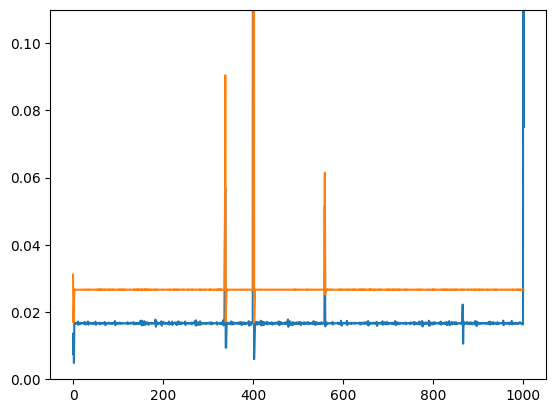

In [38]:

plt.plot(np.diff(new_synced_time_vector))
#plt.plot(np.diff(synced_time_vector))
plt.plot(np.diff(behavior_time_vector)+0.01)
plt.ylim(0, 0.11)

In [39]:
print(new_synced_time_vector[-5:])
print(beh_times[-5:])

[17.24276386 17.25903286 17.27582986 18.75782685 18.83296785]
[17.239597 17.256289 17.272928 17.289602 17.306309]


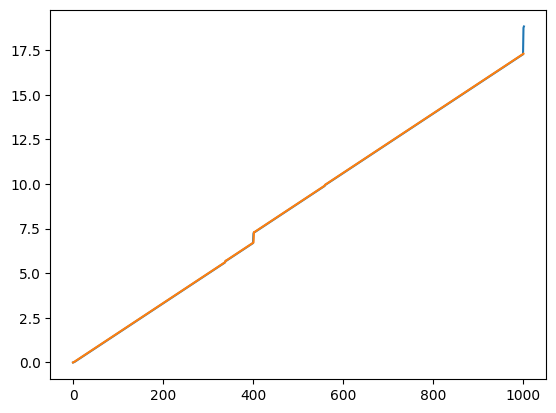

In [40]:
trial_plot = 99
plt.plot((iteration_dict['iter_times_idx'][trial_plot]))
plt.plot((behavior_time[trial_plot].flatten()))


In [10]:
trial_plot = 117
samp_before = 800
samp_after = 800
last_iter_trial0 = iteration_dict['iter_start_idx'][trial_plot-1][-1]-np.int64(samp_before)
first_iter_trial1 = iteration_dict['iter_start_idx'][trial_plot][0]+np.int64(samp_after)
second_iter_trial1 = iteration_dict['iter_start_idx'][trial_plot][0]

samp_diff = iteration_dict['iter_start_idx'][trial_plot][0] - iteration_dict['iter_start_idx'][trial_plot-1][-1]
samp_diff

np.int64(468)

### Plot signals around start of a trial

2068
samples_after_second_pulse 0
1268
time from niDAQ 18.9888268490428
time behavior [18.332542]
samples nidaq 575419
iter nidaq (1057,)
iter_virmen (1059, 1)


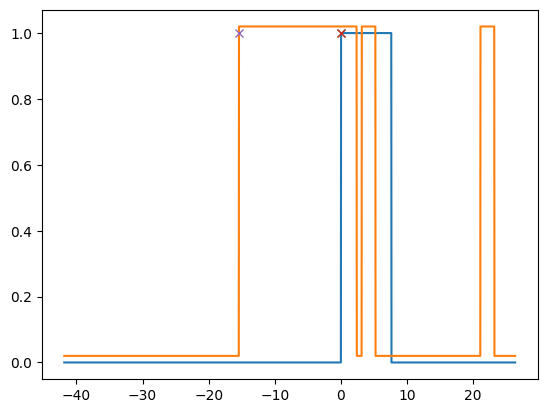

In [11]:


start_iter = 1
end_iter = 1


sample_start =(iteration_dict['iter_start_idx'][trial_plot][start_iter]-np.int64(samp_before))
sample_end = (iteration_dict['iter_start_idx'][trial_plot][end_iter]+np.int64(samp_after))

iter_sample = digital_array[new_trial_channel,last_iter_trial0:first_iter_trial1]

time_vector = np.linspace(start=0, stop=iter_sample.shape[0]-1,num=iter_sample.shape[0])
time_vector = (time_vector*1000/nidq_sampling_rate)
time_vector -=  ((iter_sample.shape[0]-samp_after)*1000)/nidq_sampling_rate

time_last_trial = time_vector[0] +(samp_before*1000)/nidq_sampling_rate



print(iter_sample.shape[0])
samples_after_second_pulse = (second_iter_trial1-(first_iter_trial1-samp_after))
print('samples_after_second_pulse', samples_after_second_pulse)
print(iter_sample.shape[0]-samp_after)

idx_time_zero = np.where((time_vector >= 0))
idx_time_zero = idx_time_zero[0]
idx_time_zero = idx_time_zero[0]




plt.plot(time_vector,iter_sample)
plt.plot(time_vector,digital_array[new_iteration_channel,last_iter_trial0:first_iter_trial1]+0.02)
plt.plot(0,1,"x")
plt.plot(time_vector[idx_time_zero+samples_after_second_pulse],1,"x")
plt.plot(time_last_trial,1,"x")

iter_nidaq = (iteration_dict['iter_start_idx'][trial_plot][-1]-iteration_dict['iter_start_idx'][trial_plot][0])
time = iter_nidaq/nidq_sampling_rate
iter_virmen = time*120

print('time from niDAQ', time)
print('time behavior', behavior_time[trial_plot][-1])

print('samples nidaq', iter_nidaq)
print('iter nidaq', iteration_dict['iter_start_idx'][trial_plot].shape)
print('iter_virmen',behavior_time[trial_plot].shape)

In [200]:
trial_plot = 280
samp_before = 3000
start_iter = 2704
samp_after = 600

plt.plot(digital_array[2,iteration_dict['iter_start_idx'][trial_plot][start_iter]-samp_before:iteration_dict['iter_start_idx'][trial_plot+1][0]+np.int64(samp_after)])
plt.plot(digital_array[1,iteration_dict['iter_start_idx'][trial_plot][start_iter]-samp_before:iteration_dict['iter_start_idx'][trial_plot+1][0]+np.int64(samp_after)])


iter_nidaq = (iteration_dict['iter_start_idx'][trial_plot][-1]-iteration_dict['iter_start_idx'][trial_plot][0])
time = iter_nidaq/nidq_sampling_rate
iter_virmen = time*120

print('time from niDAQ', time)
print('time behavior', behavior_time[trial_plot][-1])

print('samples nidaq', iter_nidaq)
print('iter nidaq', iteration_dict['iter_start_idx'][trial_plot].shape)
print('iter_virmen',behavior_time[trial_plot].shape)

IndexError: index 2704 is out of bounds for axis 0 with size 1018

In [ ]:
trial_plot = 280
print(iteration_dict['iter_start_idx'][trial_plot][2704])
print(iteration_dict['iter_start_idx'][trial_plot+1][0])

97225703
97225711


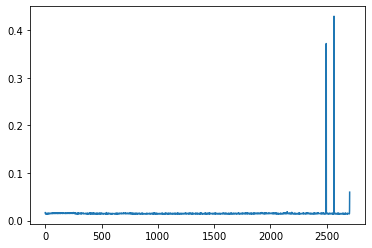

In [ ]:
plt.plot(np.diff(iteration_dict['iter_start_idx'][trial_plot]/nidq_sampling_rate))

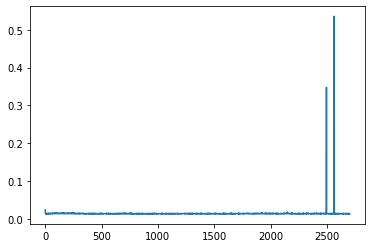

In [36]:
plt.plot(np.diff(behavior_time[trial_plot].flatten()))

In [34]:
print(behavior_time[trial_plot].flatten())

[0.0000000e+00 2.4555599e-02 3.8950201e-02 ... 4.0928226e+01 4.0943489e+01
 4.0958096e+01]


### Plot average time differences between behavior file and nidaq time

In [18]:
x = np.array([])
mean_x = np.array([])
for i in range(iteration_dict['iter_times_idx'].shape[0]-1):
    s = behavior_time[i].flatten()-iteration_dict['iter_times_idx'][i]
    mean_time_trial = np.mean(s)
    x = np.append(x,s, axis=0)
    mean_x = np.append(mean_x, mean_time_trial)

#plt.plot(x)
plt.plot(mean_x)


ValueError: operands could not be broadcast together with shapes (2704,) (2705,) 

### Test BehaviorSync insertion

In [4]:
ephys.BehaviorSync.populate(key)

nChan: 1, nFileSamp: 18400502
1
1436
1436
2
1337
1337
3
1201
1201
4
1147
1147
5
1017
1017
6
1171
1171
7
1778
1778
8
1725
1725
9
1285
1285
10
935
935
11
1008
1008
12
904
904
13
1149
1149
14
1105
1105
15
976
976
16
1210
1210
17
1088
1088
18
1090
1090
19
1190
1190
20
1025
1025
21
1645
1645
22
1816
1816
23
1859
1859
24
1854
1854
25
1630
1630
26
1022
1022
27
1048
1048
28
997
997
29
1080
1080
30
979
979
31
1047
1047
32
1021
1021
33
1022
1022
34
1082
1082
35
1105
1105
36
1013
1013
37
1786
1786
38
3131
3131
39
985
985
40
1150
1150
41
3314
3314
42
1003
1003
43
1670
1670
44
1713
1713
45
1750
1750
46
1780
1780
47
1750
1750
48
1108
1108
49
1609
1609
50
1312
1312
51
1662
1662
52
1458
1458
53
1049
1049
54
1124
1124
55
1625
1625
56
1339
1339
57
1083
1083
58
1104
1104
59
1046
1046
60
1289
1289
61
1180
1180
62
1167
1167
63
1102
1102
64
1784
1784
65
2114
2114
66
1514
1514
67
1145
1145
68
1056
1056
69
1020
1020
70
1002
1002
71
1206
1206
72
1036
1036
73
1057
1057
74
1000
1000
75
1066
1066
76
1114
1114
77


In [5]:
ephys.BehaviorSync()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
hnieh_E105,2021-01-15,0,5000.08,=BLOB=,=BLOB=
jjulian_jj042,2021-10-31,0,5000.06,=BLOB=,=BLOB=
jjulian_jj042,2021-11-01,0,5000.06,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-15,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-16,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-17,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-15,0,5000.06,=BLOB=,=BLOB=
